<font size="6">**Team 01 - Datathon - Machine Learning**</font>

# Objective : 
This notebook goes through in detail the building and evaluation of the prediction models for VitalDB dataset

# Executive Summary 

1. The best performing model is the Extreme Gradient Boosting GBM model with auc of 0.9134.
2. The important variables that contributed towards the above prediction accuracy are:
    - optype_7 - Transplanation 
    - b4_lac - Lactive
    - b4_be - Base Excess

# Machine Learnig Classification Models

## Import libararies

In [1]:
#import libararies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected = True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly import tools

#import optuna  
#from verstack import LGBMTuner

import model_func
#to make sure kernel restart is not needed after making changes in .py
import importlib
importlib.reload(model_func)

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_curve, roc_auc_score, auc


from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from datetime import datetime

from tensorflow import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras_tuner import RandomSearch
from keras.models import save_model, load_model
import random
import warnings
warnings.filterwarnings("ignore")
from keras import backend as K
from time import time
from sklearn.metrics import f1_score, accuracy_score


In [2]:
df =  pd.read_excel('01_data_compiled_selected_patients_4221.xlsx')
print(df.shape)

(4221, 84)


In [3]:
#display all columns
pd.set_option("display.max_columns",None)
df.head()

,caseid,complications,icu_days,death_inhosp,pre_post_cr,age,sex,height,weight,bmi,asa,optype,approach,emop,ane_type,preop_htn,preop_dm,preop_pft,optype_00,optype_01,optype_02,optype_03,optype_04,optype_05,optype_06,optype_07,optype_08,optype_09,optype_10,approach_00,approach_01,approach_02,ane_type_00,ane_type_01,ane_type_02,preop_pft_00,preop_pft_01,preop_pft_02,preop_pft_03,preop_pft_04,preop_pft_05,preop_pft_06,preop_pft_07,preop_pft_08,asa_00,asa_01,asa_02,asa_03,asa_04,asa_05,b4_alb,b4_alt,b4_ammo,b4_aptt,b4_ast,b4_be,b4_bun,b4_ccr,b4_cl,b4_cr,b4_crp,b4_esr,b4_fib,b4_gfr,b4_gluc,b4_hb,b4_hco3,b4_hct,b4_ica,b4_k,b4_lac,b4_na,b4_p,b4_pco2,b4_ph,b4_plt,b4_po2,b4_pt%,b4_ptinr,b4_ptsec,b4_sao2,b4_tbil,b4_tprot,b4_wbc
0,1,0,0,0,0.878049,77.0,0,160.2,67.50,26.3,cat02,Colorectal,Open,0,General,1,0,Normal,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.4,20.0,NaN,28.0,20.0,NaN,15.0,NaN,100.0,0.88,22.41,NaN,254.0,83.8,198.0,13.4,NaN,38.9,NaN,3.1,NaN,138.0,NaN,NaN,NaN,146.0,NaN,89.0,1.08,12.3,NaN,0.8,6.2,15.16
1,2,0,0,0,0.953488,54.0,0,167.3,54.80,19.6,cat02,Stomach,Open,0,General,0,0,Normal,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.1,19.0,NaN,28.6,29.0,NaN,12.0,NaN,115.0,1.02,16.18,NaN,290.0,75.9,118.0,10.2,NaN,32.5,NaN,4.7,NaN,143.0,NaN,NaN,NaN,251.0,NaN,104.0,0.97,11.1,NaN,0.5,5.2,4.36
2,7,1,3,0,NaN,52.0,1,167.7,62.30,22.2,cat02,Major resection,Videoscopic,0,General,0,0,Normal,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.4,16.0,NaN,26.4,20.0,0.8,18.0,NaN,106.0,0.84,0.09,NaN,271.0,70.9,94.0,11.8,25.4,35.1,1.17,4.4,1.2,139.0,NaN,47.0,7.34,229.0,154.0,109.0,0.95,10.8,99.0,0.4,7.4,4.28
3,9,0,0,0,NaN,32.0,1,157.9,50.90,20.4,cat01,Biliary/Pancreas,Videoscopic,0,General,0,0,Normal,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.4,8.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8,NaN,39.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.0,NaN,NaN,NaN,NaN,NaN,0.8,7.2,11.30
4,10,0,1,0,0.725000,72.0,0,162.5,62.75,23.8,cat03,Stomach,Videoscopic,0,General,1,0,Normal,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3.2,54.0,NaN,27.3,57.0,NaN,18.0,NaN,104.0,1.15,0.10,NaN,336.0,62.5,315.0,13.6,NaN,40.3,NaN,5.4,NaN,139.0,3.5,NaN,NaN,195.0,NaN,93.0,1.04,11.9,NaN,0.9,5.6,13.38


## Feature Engineering 

In [4]:
df['complications'].value_counts()

0    3957
1     264
Name: complications, dtype: int64

1. **height &  weight** removed because of BMI 
2. **death_inhosp, pre_post_cr & icu_days** removed to avoid target leakage
3. **optype** - One-Hot encoding (OHE) 
4. **approach**-OHE 
5. **ane_type**- OHE 
6. **preop_pft** - OHE
7. **asa** - OHE 

In [5]:
#dropping not required and categorical features
df= df.drop(['death_inhosp','caseid','icu_days','height','weight','pre_post_cr','approach',\
             'ane_type','asa', 'optype','preop_pft'],axis= 1)
#df = df.drop(df.filter(regex='b4').columns, axis=1)
#df = df.drop(df.filter(regex='optype_').columns, axis=1)
#df = df.drop(df.filter(regex='preop_pft_').columns, axis=1)

In [6]:
df.head()

,complications,age,sex,bmi,emop,preop_htn,preop_dm,optype_00,optype_01,optype_02,optype_03,optype_04,optype_05,optype_06,optype_07,optype_08,optype_09,optype_10,approach_00,approach_01,approach_02,ane_type_00,ane_type_01,ane_type_02,preop_pft_00,preop_pft_01,preop_pft_02,preop_pft_03,preop_pft_04,preop_pft_05,preop_pft_06,preop_pft_07,preop_pft_08,asa_00,asa_01,asa_02,asa_03,asa_04,asa_05,b4_alb,b4_alt,b4_ammo,b4_aptt,b4_ast,b4_be,b4_bun,b4_ccr,b4_cl,b4_cr,b4_crp,b4_esr,b4_fib,b4_gfr,b4_gluc,b4_hb,b4_hco3,b4_hct,b4_ica,b4_k,b4_lac,b4_na,b4_p,b4_pco2,b4_ph,b4_plt,b4_po2,b4_pt%,b4_ptinr,b4_ptsec,b4_sao2,b4_tbil,b4_tprot,b4_wbc
0,0,77.0,0,26.3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.4,20.0,NaN,28.0,20.0,NaN,15.0,NaN,100.0,0.88,22.41,NaN,254.0,83.8,198.0,13.4,NaN,38.9,NaN,3.1,NaN,138.0,NaN,NaN,NaN,146.0,NaN,89.0,1.08,12.3,NaN,0.8,6.2,15.16
1,0,54.0,0,19.6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.1,19.0,NaN,28.6,29.0,NaN,12.0,NaN,115.0,1.02,16.18,NaN,290.0,75.9,118.0,10.2,NaN,32.5,NaN,4.7,NaN,143.0,NaN,NaN,NaN,251.0,NaN,104.0,0.97,11.1,NaN,0.5,5.2,4.36
2,1,52.0,1,22.2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.4,16.0,NaN,26.4,20.0,0.8,18.0,NaN,106.0,0.84,0.09,NaN,271.0,70.9,94.0,11.8,25.4,35.1,1.17,4.4,1.2,139.0,NaN,47.0,7.34,229.0,154.0,109.0,0.95,10.8,99.0,0.4,7.4,4.28
3,0,32.0,1,20.4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.4,8.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8,NaN,39.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.0,NaN,NaN,NaN,NaN,NaN,0.8,7.2,11.30
4,0,72.0,0,23.8,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3.2,54.0,NaN,27.3,57.0,NaN,18.0,NaN,104.0,1.15,0.10,NaN,336.0,62.5,315.0,13.6,NaN,40.3,NaN,5.4,NaN,139.0,3.5,NaN,NaN,195.0,NaN,93.0,1.04,11.9,NaN,0.9,5.6,13.38


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   complications  4221 non-null   int64  
 1   age            4221 non-null   float64
 2   sex            4221 non-null   int64  
 3   bmi            4221 non-null   float64
 4   emop           4221 non-null   int64  
 5   preop_htn      4221 non-null   int64  
 6   preop_dm       4221 non-null   int64  
 7   optype_00      4221 non-null   int64  
 8   optype_01      4221 non-null   int64  
 9   optype_02      4221 non-null   int64  
 10  optype_03      4221 non-null   int64  
 11  optype_04      4221 non-null   int64  
 12  optype_05      4221 non-null   int64  
 13  optype_06      4221 non-null   int64  
 14  optype_07      4221 non-null   int64  
 15  optype_08      4221 non-null   int64  
 16  optype_09      4221 non-null   int64  
 17  optype_10      4221 non-null   int64  
 18  approach

## Correlation 

In [8]:
data_corr = df.select_dtypes(include=[np.number])
#Generate correlation matrix
corrMatrix = data_corr.corr()
corrMatrix.head(20)

,complications,age,sex,bmi,emop,preop_htn,preop_dm,optype_00,optype_01,optype_02,optype_03,optype_04,optype_05,optype_06,optype_07,optype_08,optype_09,optype_10,approach_00,approach_01,approach_02,ane_type_00,ane_type_01,ane_type_02,preop_pft_00,preop_pft_01,preop_pft_02,preop_pft_03,preop_pft_04,preop_pft_05,preop_pft_06,preop_pft_07,preop_pft_08,asa_00,asa_01,asa_02,asa_03,asa_04,asa_05,b4_alb,b4_alt,b4_ammo,b4_aptt,b4_ast,b4_be,b4_bun,b4_ccr,b4_cl,b4_cr,b4_crp,b4_esr,b4_fib,b4_gfr,b4_gluc,b4_hb,b4_hco3,b4_hct,b4_ica,b4_k,b4_lac,b4_na,b4_p,b4_pco2,b4_ph,b4_plt,b4_po2,b4_pt%,b4_ptinr,b4_ptsec,b4_sao2,b4_tbil,b4_tprot,b4_wbc
complications,1.000000,-0.008909,-0.074019,-0.064579,NaN,0.011674,0.019478,-0.077737,-0.051351,-0.049691,0.013071,0.050824,-0.053772,-0.047760,0.340179,-0.053879,-0.016550,0.031644,0.082909,-0.074514,-0.020866,0.011444,-0.020025,0.012159,-0.056263,0.002362,0.049845,0.032623,0.018866,0.017458,0.023453,0.039335,-0.003976,-0.095245,-0.052312,0.213492,-0.012423,-0.009745,0.101220,-0.167970,0.012913,0.213106,0.087941,0.043568,0.350902,0.064527,0.235137,-0.025785,0.069284,0.046226,0.049639,-0.015244,-0.029607,0.029494,-0.081510,-0.271107,-0.096395,-0.022035,0.028273,0.389624,-0.125934,-0.025679,-0.175784,-0.058797,-0.104597,-0.097710,-0.198685,0.216937,0.217632,-0.033254,0.139321,-0.073375,-0.045172
age,-0.008909,1.000000,-0.094336,0.057388,NaN,0.351691,0.167679,0.147385,0.009352,0.060796,0.077954,-0.074684,0.016481,-0.084343,-0.233618,-0.138941,0.032380,0.014413,-0.032829,0.055303,-0.055320,0.015559,-0.022821,0.008802,-0.190876,0.228354,-0.037928,0.072516,0.068103,-0.029171,-0.017248,0.031999,-0.001744,0.235120,-0.297640,0.058567,-0.012279,-0.029490,-0.010301,-0.203430,-0.026013,0.013605,-0.128759,0.030034,-0.145849,0.032432,-0.022468,0.044606,-0.113610,0.070134,0.096437,0.157774,-0.224256,0.169177,-0.133437,0.028552,-0.141284,-0.160767,0.014808,-0.061291,0.009904,-0.117422,0.056087,-0.046069,-0.094180,-0.117997,0.077709,-0.072532,-0.072589,-0.010082,-0.010704,-0.145845,0.031217
sex,-0.074019,-0.094336,1.000000,-0.010117,NaN,-0.069687,-0.054123,-0.051815,0.044785,-0.047986,-0.017575,-0.033683,0.025327,0.220815,-0.008011,0.080503,-0.101409,-0.035286,0.006697,0.010856,-0.043274,0.036063,-0.046688,0.009508,0.195496,-0.175224,-0.005317,-0.095369,-0.066780,-0.023285,-0.011359,-0.020137,0.016644,-0.055101,0.115401,-0.071035,0.006888,-0.034895,-0.018448,0.009727,-0.058651,-0.111674,-0.012145,-0.005084,-0.093880,-0.080177,-0.107234,0.100444,-0.092604,-0.057075,-0.003052,-0.025056,0.093865,-0.070641,-0.307297,-0.021486,-0.278516,0.113450,-0.132643,-0.123647,0.098498,0.178702,-0.081521,0.069785,0.113107,0.069220,0.115474,-0.095672,-0.095671,0.001923,-0.073134,0.022658,-0.057240
bmi,-0.064579,0.057388,-0.010117,1.000000,NaN,0.173192,0.053262,-0.015822,0.058730,-0.064460,0.046188,-0.090875,0.016686,0.044581,-0.064793,0.096490,0.021904,-0.016518,-0.069514,0.039060,0.075205,0.018130,0.010183,-0.054281,0.099165,-0.035290,-0.077679,-0.022953,-0.015285,-0.069726,-0.032497,0.003754,-0.025156,0.077466,-0.028351,-0.078873,0.010450,-0.050206,-0.001475,0.127156,0.076367,-0.085639,-0.076670,0.013309,-0.041223,-0.083436,0.023786,0.087714,-0.097672,-0.012624,-0.049818,-0.025927,-0.061543,0.054926,0.229011,0.061665,0.216970,0.061573,-0.045008,0.008616,0.114138,0.018243,0.050596,0.006112,-0.028046,-0.206409,0.108119,-0.089342,-0.089452,0.045210,-0.038068,0.110658,0.006427
emop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
preop_htn,0.011674,0.351691,-0.069687,0.173192,NaN,1.000000,0.148003,0.054002,0.013575,0.005444,0.033480,-0.065367,-0.015935,-0.046769,-0.018890,-0.061722,0.015168,0.052810,0.006331,0.000672,-0.017273,0.005741,-0.020419,0.024303,-0.068156,0.058089,0.009507,0.024641,0.035196,-0.0

In [9]:
#show the correlation with respect to target variable
corrMatrix.sort_values(['complications'], ascending=False, inplace=True)
corrMatrix['complications']

complications    1.000000
b4_lac           0.389624
b4_be            0.350902
optype_07        0.340179
b4_ccr           0.235137
                   ...   
b4_alb          -0.167970
b4_pco2         -0.175784
b4_pt%          -0.198685
b4_hco3         -0.271107
emop                  NaN
Name: complications, Length: 73, dtype: float64

In [10]:

corrMatrix= corrMatrix.head(10)
import plotly.figure_factory as ff
x = list(corrMatrix.columns)
y = list(corrMatrix.index)
z = np.array(corrMatrix)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Viridis'
    )
fig.update_layout(title_text="Correaltion Matrix",template='plotly_white',\
                  width=1200, height=500)
fig.show()

## Train - Test Split

In [11]:
# X - all the feature columns except target variable
X= df.drop(['complications'],axis= 1)
# y - target variable
y= df['complications']

#80% training data set and 20% validation set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print("%r, %r, %r" % (X.shape, X_train.shape, X_test.shape))

(4221, 72), (3376, 72), (845, 72)


## Simple Imputer

In [12]:
#imputing for model that are not able to handle missing values. 
from sklearn.impute import SimpleImputer
nan_col =  df.filter(regex='b4').columns.to_list()


X_train_imputed=X_train.copy()
X_test_imputed=X_test.copy()

#fit training data col
imp = SimpleImputer()

# transform training data column 
X_train_imputed[nan_col] =pd.DataFrame(imp.fit_transform(X_train[nan_col]),
                   columns=nan_col,index=X_train.index)

#transform the testing data column
X_test_imputed[nan_col]=pd.DataFrame(imp.transform(X_test[nan_col]),
                   columns=nan_col,index=X_test.index)

In [13]:
X_test_imputed

,age,sex,bmi,emop,preop_htn,preop_dm,optype_00,optype_01,optype_02,optype_03,optype_04,optype_05,optype_06,optype_07,optype_08,optype_09,optype_10,approach_00,approach_01,approach_02,ane_type_00,ane_type_01,ane_type_02,preop_pft_00,preop_pft_01,preop_pft_02,preop_pft_03,preop_pft_04,preop_pft_05,preop_pft_06,preop_pft_07,preop_pft_08,asa_00,asa_01,asa_02,asa_03,asa_04,asa_05,b4_alb,b4_alt,b4_ammo,b4_aptt,b4_ast,b4_be,b4_bun,b4_ccr,b4_cl,b4_cr,b4_crp,b4_esr,b4_fib,b4_gfr,b4_gluc,b4_hb,b4_hco3,b4_hct,b4_ica,b4_k,b4_lac,b4_na,b4_p,b4_pco2,b4_ph,b4_plt,b4_po2,b4_pt%,b4_ptinr,b4_ptsec,b4_sao2,b4_tbil,b4_tprot,b4_wbc
3717,68.0,0,20.7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.30000,17.000000,80.22449,30.9,18.000000,1.400000,14.000000,56.605505,104.000000,0.720000,0.03000,34.646199,235.0,108.40000,103.000000,11.300000,22.700000,34.400000,1.040000,4.60000,3.300000,141.000000,3.508323,35.000000,7.420000,275.00000,272.000000,81.0,1.15,13.1,100.00000,0.500000,6.300000,7.150000
188,79.0,0,22.5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,3.90000,21.000000,80.22449,29.2,24.000000,2.509245,17.000000,56.605505,107.000000,0.930000,2.99000,34.646199,240.0,78.30000,105.000000,11.600000,25.510242,34.500000,1.148959,3.90000,1.869516,140.000000,3.508323,44.738407,7.367064,149.00000,166.226174,96.0,1.03,11.7,96.01707,0.400000,7.000000,3.850000
2778,42.0,0,25.6,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.70000,44.000000,80.22449,34.7,22.000000,0.200000,11.000000,56.605505,103.000000,0.770000,0.04000,34.646199,241.0,110.40000,134.000000,16.500000,27.200000,46.800000,1.130000,4.30000,2.900000,142.000000,3.508323,54.000000,7.310000,238.00000,169.000000,110.0,0.94,10.7,99.00000,0.400000,6.800000,8.420000
4102,20.0,0,21.8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.95254,26.488328,80.22449,40.9,27.196215,2.509245,16.663785,56.605505,104.255038,1.128527,2.96033,34.646199,188.0,87.43298,125.381418,12.623864,25.510242,38.393617,1.148959,4.17474,1.869516,140.400126,3.508323,44.738407,7.367064,234.66868,166.226174,90.0,1.07,12.2,96.01707,0.725339,6.827106,7.163149
1910,53.0,1,19.9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.40000,32.000000,80.22449,23.4,46.000000,2.509245,12.000000,56.605505,110.000000,0.580000,3.17000,120.000000,232.0,108.60000,82.000000,9.600000,25.510242,31.300000,1.148959,3.70000,1.869516,143.000000,3.508323,44.738407,7.367064,96.00000,166.226174,94.0,1.04,11.9,96.01707,0.900000,7.800000,2.810000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,76.0,1,21.7,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.60000,36.000000,80.22449,29.1,66.000000,2.509245,15.000000,56.605505,105.000000,1.270000,2.96033,34.646199,283.0,40.90000,120.000000,9.400000,25.510242,29.400000,1.148959,4.20000,1.869516,141.000000,2.700000,44.738407,7.367064,133.00000,166.226174,113.0,0.93,10.6,96.01707,0.600000,7.200000,3.880000
2221,73.0,1,21.5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.70000,18.000000,80.22449,28.4,21.000000,2.509245,13.000000,56.605505,107.000000,0.580000,4.95000,34.646199,380.0,101.80000,103.000000,11.600000,25.510242,34.900000,1.148959,3.90000,1.869516,142.000000,3.508323,44.738407,7.367064,136.00000,166.226174,93.0,1.04,11.9,96.01707,1.100000,6.600000,4.670000
2115,67.0,0,26.7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.60000,14.000000,80.22449,32.9,17.000000,2.509245,10.000000,56.605505,105.000000,0.820000,2.96033,34.646199,218.0,93.50000,125.381418,12.900000,25.510242,39.100000,1.148959,3.70000,1.869516,142.000000,3.508323,44.738407,7.367064,81.00000,166.226174,91.0,1.06,12.1,96.01707,1.

## Feature Scaling

We have used feature scaling for logistic regresion, ridge classifier, SVM, KNN and neural network because they are sensitive to feature scaling.

1. **Gradient Descent Based Algorithms** : ML algorithms like linear regression, logistic regression, neural network, etc. that use gradient descent as an optimization technique require data to be scaled. To ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features, data is scaled before feeding to the model. Having features on a similar scale can help the gradient descent converge more quickly towards the minima

2. **Distance-Based algorithms** like KNN, K-means, and SVM are most affected by the range of features. This is because they are using distances between data points to determine their similarity. This is because if features have different scales, there is a chance that higher weightage is given to features with higher magnitude. This will impact the performance of the machine learning algorithm and make it biassed towards one feature.

3. **Tree-based algorithms**  are fairly insensitive to the scale of the features. This is because the decision tree splits a node on a feature that increases the homogeneity of the node. This split on a feature is not influenced by other features. So, there is virtually no effect of the remaining features on the split. This makes them invariant to the scale of the features.

In [14]:
num_cols = X_train.select_dtypes(exclude = ['object']).columns.to_list()

#Standardization for Logistic Regression, Ridge classifier, 
X_train_scaled=X_train_imputed.copy()
X_test_scaled=X_test_imputed.copy()

#Feature scaling for Linear models 
scaler = StandardScaler()
#fit and transform the training data column
X_train_scaled[num_cols]=pd.DataFrame(scaler.fit_transform(X_train_imputed[num_cols]),
                   columns=num_cols,index=X_train_imputed.index)
#transform the testing data column
X_test_scaled[num_cols]=pd.DataFrame(scaler.transform(X_test_imputed[num_cols]),
                   columns=num_cols,index=X_test_imputed.index)


In [15]:
X_train_scaled.head()

,age,sex,bmi,emop,preop_htn,preop_dm,optype_00,optype_01,optype_02,optype_03,optype_04,optype_05,optype_06,optype_07,optype_08,optype_09,optype_10,approach_00,approach_01,approach_02,ane_type_00,ane_type_01,ane_type_02,preop_pft_00,preop_pft_01,preop_pft_02,preop_pft_03,preop_pft_04,preop_pft_05,preop_pft_06,preop_pft_07,preop_pft_08,asa_00,asa_01,asa_02,asa_03,asa_04,asa_05,b4_alb,b4_alt,b4_ammo,b4_aptt,b4_ast,b4_be,b4_bun,b4_ccr,b4_cl,b4_cr,b4_crp,b4_esr,b4_fib,b4_gfr,b4_gluc,b4_hb,b4_hco3,b4_hct,b4_ica,b4_k,b4_lac,b4_na,b4_p,b4_pco2,b4_ph,b4_plt,b4_po2,b4_pt%,b4_ptinr,b4_ptsec,b4_sao2,b4_tbil,b4_tprot,b4_wbc
3123,0.454138,1.101713,-1.427956,0.0,1.452121,-0.359301,1.816766,-0.378987,-0.341718,-0.354554,-0.339552,-0.347099,-0.198517,-0.259502,-0.208772,-0.228843,-0.150733,-0.953112,1.042985,-0.217132,0.176507,-0.150733,-0.089789,0.458297,-0.300731,-0.211844,-0.146569,-0.132214,-0.062174,-0.071141,-0.024347,0.0,-1.262904,-0.583735,2.787262,-0.120096,-0.042195,-0.034442,-0.108769,-0.312436,2.707535e-15,-0.003049,-0.301624,0.000000,-0.663591,-7.451957e-16,-0.074259,-0.365168,-3.129426e-01,3.421322e-01,0.221037,0.832716,-0.324360,0.306642,0.522325,0.430353,-2.247299,-1.672878,-7.841551e-01,-0.141873,0.562281,-1.074739,1.862968e+00,-0.284952,9.246465e+00,0.417484,-0.383145,-0.358288,7.260707e-01,-0.330568,0.703786,-0.480257
1345,-0.732451,1.101713,-0.280083,0.0,-0.688648,-0.359301,-0.550429,-0.378987,-0.341718,2.820444,-0.339552,-0.347099,-0.198517,-0.259502,-0.208772,-0.228843,-0.150733,-0.953112,1.042985,-0.217132,0.176507,-0.150733,-0.089789,0.458297,-0.300731,-0.211844,-0.146569,-0.132214,-0.062174,-0.071141,-0.024347,0.0,0.791826,-0.583735,-0.358775,-0.120096,-0.042195,-0.034442,0.512294,-0.421220,2.707535e-15,-0.214806,-0.375225,0.000000,-0.230652,-7.451957e-16,-0.074259,-0.270487,-5.953433e-01,7.248479e-16,0.171772,0.062702,-0.809379,0.093746,0.000000,0.157284,0.000000,0.310555,-5.201294e-16,0.212699,0.369506,0.000000,2.629097e-14,-0.184390,1.406200e-15,0.343052,-0.383145,-0.358288,2.590576e-15,-0.228961,1.001437,0.053666
2578,0.384339,1.101713,0.322550,0.0,1.452121,-0.359301,-0.550429,2.638610,-0.341718,-0.354554,-0.339552,-0.347099,-0.198517,-0.259502,-0.208772,-0.228843,-0.150733,-0.953112,1.042985,-0.217132,0.176507,-0.150733,-0.089789,0.458297,-0.300731,-0.211844,-0.146569,-0.132214,-0.062174,-0.071141,-0.024347,0.0,0.791826,-0.583735,-0.358775,-0.120096,-0.042195,-0.034442,0.305273,0.122699,2.707535e-15,-0.680672,-0.154422,0.000000,-0.057476,-7.451957e-16,-0.074259,-0.365168,-9.022381e-17,7.248479e-16,-0.591826,0.839813,-0.324360,-0.172373,0.000000,-0.135289,0.000000,-0.929090,-5.201294e-16,-1.205590,0.000000,0.000000,2.629097e-14,-0.071257,1.406200e-15,0.343052,-0.383145,-0.358288,2.590576e-15,-0.330568,0.703786,-0.290489
4017,0.942734,1.101713,-0.538354,0.0,-0.688648,-0.359301,-0.550429,-0.378987,2.926387,-0.354554,-0.339552,-0.347099,-0.198517,-0.259502,-0.208772,-0.228843,-0.150733,-0.953112,1.042985,-0.217132,0.176507,-0.150733,-0.089789,-2.181993,-0.300731,4.720462,-0.146569,-0.132214,-0.062174,-0.071141,-0.024347,0.0,-1.262904,-0.583735,2.787262,-0.120096,-0.042195,-0.034442,-1.557917,-0.448416,2.707535e-15,0.378113,0.360783,0.090506,1.154756,-7.451957e-16,-1.238929,-0.194743,-5.526784e-01,7.248479e-16,-1.330793,-0.671828,-0.176746,-3.898048,-0.374816,-4.172801,0.021480,0.062626,-1.985414e-01,-3.687594,0.000000,-1.074739,9.749383e-01,-2.057362,-3.592624e+00,-4.495071,7.032522,7.002409,-1.112314e+01,0.279075,-1.082119,-1.046344
842,1.082333,1.101713,2.417418,0.0,1.452121,2.783184,-0.550429,-0.378987,2.926387,-0.354554,-0.339552,-0.347099,-0.198517,-0.259502,-0.208772,-0.228843,-0.150733,-0.953112,1.042985,-0.217132,0.176507,-0.150733,-0.089789,0.458297,-0.300731,-0.211844,-0.146569,-0.132214,-0.062174,-0.071141,-0.024347,0.0,-1.262904,-0.583735,2.787262,-0.120096,-0.042195,-0.034442,-0.729833,1.128951,2.707535e-15,-1.548876,1.796000,-0.208671,-0.836767,-7.451957e-16,-1.238929,-0.390416,-5.709634e-01,7.248479e-16

## Feature Selection 

We planned to used random forest to select features. (Not incorporated)

Feature selection using Random forest comes under the category of Embedded methods. Embedded methods combine the qualities of filter and wrapper methods. They are implemented by algorithms that have their own built-in feature selection methods. Some of the benefits of embedded methods are :
- They are highly accurate.
- They generalize better.
- They are interpretable

The main idead behind selecting the features using random forest is that when training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of the variable.

In [16]:
#select the features using SelectFromModel
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators=500))
sel.fit(X_train_imputed, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=500))

In [17]:
#view important features
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['age', 'bmi', 'optype_07', 'b4_alb', 'b4_alt', 'b4_ammo', 'b4_aptt',
       'b4_ast', 'b4_be', 'b4_bun', 'b4_ccr', 'b4_cl', 'b4_cr', 'b4_crp',
       'b4_esr', 'b4_fib', 'b4_gfr', 'b4_gluc', 'b4_hb', 'b4_hco3', 'b4_hct',
       'b4_k', 'b4_lac', 'b4_na', 'b4_p', 'b4_pco2', 'b4_ph', 'b4_plt',
       'b4_po2', 'b4_pt%', 'b4_ptinr', 'b4_ptsec', 'b4_sao2', 'b4_tbil',
       'b4_tprot', 'b4_wbc'],
      dtype='object')


In [18]:
#total features count 
len(selected_feat)

36

In [19]:
# #train and test set with selected features 
# X_train= X_train[selected_feat]
# X_test = X_test[selected_feat]

# Modeling

This section deals with building multiple models on the  dataset and then comparing the different model to determine which model is best in terms of performance.

The list of models tried out are:
* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [Ridge Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)
* [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/svm.html)
* [K-Nearest Neighbour (KNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Gradient Boost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
* [Xgboost](https://xgboost.readthedocs.io/en/stable/)
* [Light Gbm](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
* [Keras Neural Network](https://keras.io/guides/)

## K fold validation 

In this section, we will try out different models across kfold and pick the best for hyperparamter tuning. 

In [20]:
#Implememt 5-fold cross validation for all models. Use standardize data for Logistic regression, Ridge, SVM, KNN 
def model_comparision (results,names,models,n_spilts, random_state,scoring, X_train, X_train_scaled,y_train):
    for name, model in models:
        if name in ('LR','RC','SVM','KNN','RF','GB'):
            X_train = X_train_scaled
        else:
             X_train = X_train
        kf = StratifiedKFold(n_splits=n_spilts, random_state=random_state)
        start_time = datetime.now()
        print('\033[1m'+ '\033[4m' + name +'\033[0m')
        print("Start Time: {}" .format(start_time))
        cv_results = cross_val_score(model , X_train, y_train,  scoring=scoring,cv = kf)
        end_time = datetime.now()
        print("End Time: {}" .format(end_time))
        print('Total time taken:' + '\033[1m' + str(end_time - start_time) + '\033[0m')
        #add results per model
        results.append(cv_results)
        names.append(name)
        print("mean roc_auc: " + '\033[1m'+'\033[92m' + str(np.round(cv_results.mean(),4)) \
              +'\033[0m'+ ", mean std: " + str(np.round(cv_results.std(),4)))
        print("All {} scores : {}" .format(n_spilts, cv_results))

In [21]:

results = []
names   = []
models  = []
models.append(('LR',LogisticRegression()))
models.append(('RC',RidgeClassifier(alpha=1.0)))   
models.append(('SVM',SVC(kernel='sigmoid'))) 
models.append(('KNN',KNeighborsClassifier(n_neighbors=5))) 
models.append(('RF',RandomForestClassifier()))
models.append(('GB',GradientBoostingClassifier()))
#models.append(('Cat Boost',CatBoostClassifier('verbose'= False)))
models.append(('Extreme Gradient Boost',XGBClassifier()))
models.append(('Light GBM',LGBMClassifier()))
model_comparision(results,names,models, 5, None, 'roc_auc',X_train,X_train_scaled, y_train)

LR
Start Time: 2022-12-04 07:14:27.838774
End Time: 2022-12-04 07:14:28.182770
Total time taken:0:00:00.343996
mean roc_auc: 0.809, mean std: 0.0488
All 5 scores : [0.82302803 0.72034153 0.79714888 0.85195216 0.85229068]
RC
Start Time: 2022-12-04 07:14:28.182770
End Time: 2022-12-04 07:14:28.251789
Total time taken:0:00:00.069019
mean roc_auc: 0.8035, mean std: 0.066
All 5 scores : [0.7880892  0.6918679  0.79669751 0.87801851 0.86274731]
SVM
Start Time: 2022-12-04 07:14:28.251789
End Time: 2022-12-04 07:14:28.727769
Total time taken:0:00:00.475980
mean roc_auc: 0.5536, mean std: 0.0775
All 5 scores : [0.52029832 0.61069736 0.57481381 0.64123975 0.42108629]
KNN
Start Time: 2022-12-04 07:14:28.728766
End Time: 2022-12-04 07:14:28.925763
Total time taken:0:00:00.196997
mean roc_auc: 0.7102, mean std: 0.051
All 5 scores : [0.65998016 0.63871963 0.76600466 0.73664711 0.74954863]
RF
Start Time: 2022-12-04 07:14:28.926763
End Time: 2022-12-04 07:14:31.859876
Total time taken:0:00:02.933113
me

In [22]:
#plot to show auc comparison for k-fold cross validation
fig = go.Figure()

for xd, yd in zip(names, results):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1,marker_color = '#00acee')
        )
fig.update_layout(title_text="<i><b>Model Performance</b></i>",
                 yaxis_title="Area under the curve(AUC)",xaxis_title="Models",
                showlegend=False)

fig.update_layout(template='plotly_white')
fig.show()


**Observation** We see the best performing model is Gradient Boostisting with roc_auc of 0.8706 across the 5 k stratified folds.
We have decided to evaluate logistic regression and Extreme Gradient Boosting further because Logistic regression is a simple and explainable model while XGboost gives the prediction without imputation. 
Hence, even though Gradient Boostisting has performed the best, we have not selected to evaluate further because of the missing values in biomarkers which are being imputed using simple imputer. 

## Binary Classification with Neural Networks

In [23]:
def build_model(hp):

    # create model object
    model = keras.Sequential([
      layers.Input(shape=(X_train_scaled.shape[1],)),
      layers.Dense(
          units=hp.Int('dense_1_units', min_value=16, max_value=512, step=16),
          activation='relu'
      ),
      layers.Dropout(
          hp.Choice('dropout_1', values = [0.1, 0.2, 0.3, 0.4])
      ),
      layers.Dense(
          units=hp.Int('dense_2_units', min_value=16, max_value=512, step=16),
          activation='relu'
      ),
      layers.Dropout(
          hp.Choice('dropout_2', values = [0.1, 0.2, 0.3, 0.4])
      ),
      layers.Dense(
          units=hp.Int('dense_3_units', min_value=16, max_value=512, step=16),
          activation='relu'
      ),
      layers.Dropout(
          hp.Choice('dropout_3', values = [0.1, 0.2, 0.3, 0.4])
      ),
      # output layer    
      layers.Dense(1, activation='sigmoid', name = 'Output') # output
    ])
    #compilation of model
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC()]
        )
    # return model
    return model

In [24]:
start_time = datetime.now()
print("Start Time: {}" .format(start_time))

#creating randomsearch object
nn_tuner = RandomSearch(build_model, objective='val_loss', max_trials = 50)

# search best parameter
nn_tuner.search(X_train_scaled, y_train, epochs=10, validation_data=(X_test_scaled, y_test))

end_time = datetime.now()
print("End Time: {}" .format(end_time))
print('Total time taken:' + '\033[1m' + str(end_time - start_time) + '\033[0m')

Start Time: 2022-12-04 07:14:41.860466
INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
End Time: 2022-12-04 07:14:42.324466
Total time taken:0:00:00.464000


In [25]:
# # After tuning, get best model and print summary
# nn_model = nn_tuner.get_best_models(num_models=1)[0]

# #summary of best model
# nn_model.summary()

In [26]:
# # Get evaluation results
# nn_model.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = nn_model.predict(X_test_scaled)
# y_pred_class = list(map(lambda x: 1 if x > 0.5 else 0, y_pred)) # Map output prob to class

# # Call evaluation functions from sklearn to evaluate model
# acc = accuracy_score(y_test, y_pred_class)

In [27]:
# confusion_matrix = metrics.confusion_matrix(y_test, y_pred_class)
# confusion_matrix

##  Logistic Regression

In [28]:
model = LogisticRegression()
model_func.fit_model(model,'Logistic Regression Classifier','lr.sav',X_train_imputed,y_train)

Logistic Regression Classifier
Start Time: 2022-12-04 07:14:42.456467
End Time: 2022-12-04 07:14:42.546465
Total time taken:0:00:00.089998


In [29]:
model_func.c_matrix('lr.sav','Post-Operative Complications',y_test,X_test_imputed)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       792
           1       0.65      0.28      0.39        53

    accuracy                           0.95       845
   macro avg       0.80      0.64      0.68       845
weighted avg       0.93      0.95      0.94       845



In [30]:
model_func.plot_auc('lr.sav',y_test,X_test_imputed)

## XGBM - Best Model with imputation

In [31]:
model = XGBClassifier(learning_rate = 0.01,
                             max_depth= 8,
                             random_state= 42,
                             n_estimators= 300)
model_func.fit_model(model,'XGB Classifier','trained_xgbm.sav',X_train,y_train)

XGB Classifier
Start Time: 2022-12-04 07:14:42.865464
End Time: 2022-12-04 07:14:46.204436
Total time taken:0:00:03.338972


In [32]:
model_func.c_matrix('trained_xgbm.sav','Post-Operative Complications',y_test,X_test)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       792
           1       0.60      0.40      0.48        53

    accuracy                           0.95       845
   macro avg       0.78      0.69      0.72       845
weighted avg       0.94      0.95      0.94       845



In [33]:
model_func.plot_auc('trained_xgbm.sav',y_test,X_test)

In [34]:
model_func.feature_importance('trained_xgbm.sav',X_train,"Top Important Features")

# XAI

<font size = 5  color = '#008B8B'> **XAI why?** </font>
-  ML/AI models are getting more complex and challenging and hence the need to interpret and explain is even more
-  XAI is a regulartory requirement and a key transparency pillar for most of the industries deploying AI


<img src="https://www.darpa.mil/ddm_gallery/xai-figure1-inline-graphic.png" align = 'left' width = 500 length = 500>

<br clear="left"/>
    
*A simple [infographic](https://www.darpa.mil/ddm_gallery/xai-figure1-inline-graphic.png) above shows the flow of AI to Questions*

<font size = 5  color = '#008B8B'> **What does XAI answer?** </font>
- Why did the AI system make a specific prediction or decision?
- Why didn’t the AI system do something else?
- When do AI systems give enough confidence in the decision that you can trust it, and how can the AI system correct errors that arise?
    
<img src="https://miro.medium.com/max/1100/1*jQXEEEOWuSGJT9KwD8DEhA.png" align = 'left' width = 500 length = 500> 
<br clear="left"/>

*A simple [infographic](https://www.researchgate.net/profile/Jordi-Vallverdu/publication/339079867/figure/fig1/AS:855646786297857@1581013499668/Explainability-in-deep-learning-DL.ppm) above illustrates some of state-of-the-art techniques in the accuracy-interpretability trade-off map*


<b>What is SHAP?</b></font>
<ul>
  <li>SHAP — which stands for SHapley Additive exPlanations — is a <b>brilliant way to reverse-engineer the output of any predictive algorithm</b></li>
  <li>Published in 2017 by Lundberg and Lee, SHAP is probably the state of the art in Machine Learning explainability</li>
  <li>Three main “explainer” classes - </li>
   <ul>
	  <li>TreeExplainer (Model Specific)</li>
	  <li>DeepExplainer (Model Specific)</li>
      <li>KernelExplainer (Model Agnostic)</li>
   </ul>
</ul>

<font size = 4  color = '#008B8B'> <b>Idea behind SHAP - Shapely Values</b></font>
<ul>
	<li>SHAP values are based on Shapley values - a solution concept in cooperative game theory.</li>
	<li>Shapley value is the average expected <a href="https://www.igi-global.com/dictionary/marginal-contribution/39781">marginal contribution</a> of one player after <b>all possible combinations</b> have been considered.</li>
	<li>Shapley value helps to determine a payoff for all of the players when each player might have contributed more or less than the others.</li>
</ul>

<font size = 4  color = '#008B8B'> <b>How it relate to the explainability of machine learning?</b></font>
<br>  
Suppose we have a predictive model; in that case:
<ul>
<li>the <b>game</b> is reproducing the <b>outcome</b> of the model</li>
<li>the <b>players</b> are the <b>features</b> included in the model.</li>
</ul>

What Shapley does is <b>quantify each player's contribution to the game</b>. 
What SHAP does is <b>quantify the contribution that each feature makes to the model's prediction</b>.
<br>
<i>To be clear,game only refers to one observation</i>

<br>
<br>
<div style="float: left;">
<img src = "https://shap.readthedocs.io/en/latest/_images/shap_header.png" width = 450 length = 450 >
</div>
    
<br clear="left"/>

<i>A simple <a href="https://shap.readthedocs.io/en/latest/_images/shap_header.png">infographic</a> above shows SHAP helps us   understand the magnitude of impact (length of the bar) and direction(colour)</i>

<br>


## Variable Importance Plot — Global Interpretability

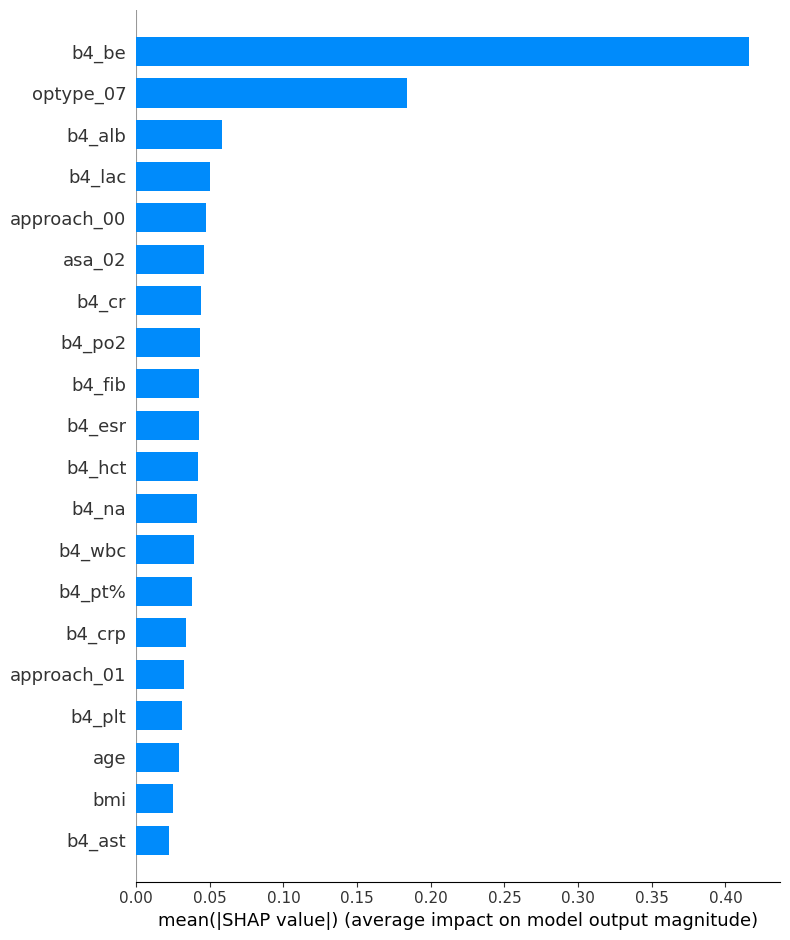

In [35]:
import shap
import pickle
model = pickle.load(open('trained_xgbm.sav', 'rb'))
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Local Explanation

In [36]:
model = pickle.load(open('trained_xgbm.sav', 'rb'))
# Fits the explainer
explainer = shap.TreeExplainer(model)
# Calculates the SHAP values
shap_values = explainer.shap_values(X_test)
expected_value = explainer.expected_value

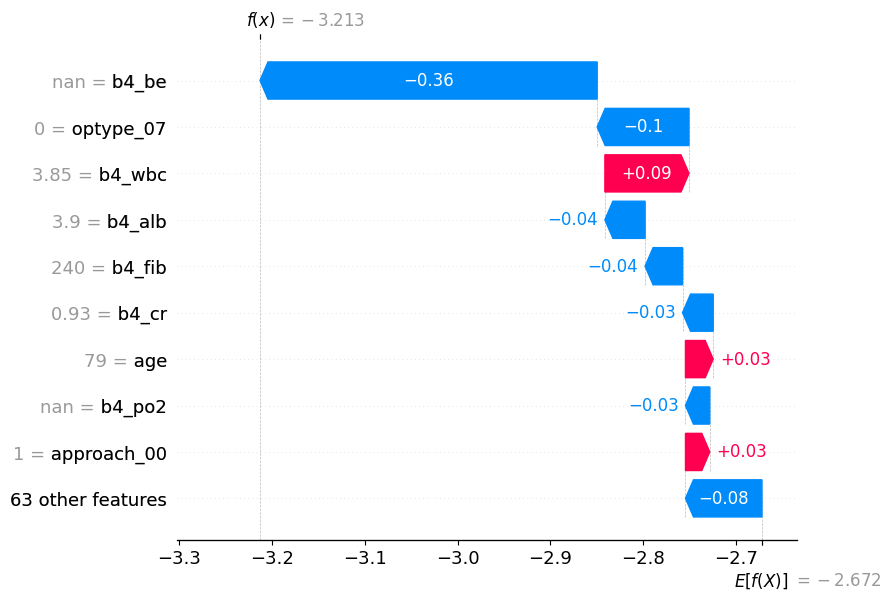

In [37]:
class ShapInput(object):
    def __init__(self, expectation, shap_values, features, feat_names):
        self.base_values = expectation
        self.values = shap_values
        self.data = features
        self.display_data = features
        self.feature_names = feat_names



shap_input = ShapInput(explainer.expected_value, shap_values[1],
                       X_test.iloc[1],
                       feat_names=X_test.columns)



shap.waterfall_plot(shap_input, max_display=10)


# Model based on Sex

In this section, we want to check if the model is biased toward any sex(female or male)

In [38]:
df_male = df[df['sex']==0] # Male =0 and Female = 1
df_female = df[df['sex']!=0] 

In [39]:
# X - all the feature columns except target variable
X_male= df_male.drop(['complications'],axis= 1)
y_male= df_male['complications']

X_female= df_female.drop(['complications'],axis= 1)
y_female= df_female['complications']



#80% training data set and 20% validation set
X_train_M, X_test_M, y_train_M, y_test_M = train_test_split( X_male, y_male, test_size=0.2, random_state=42)
print("%r, %r, %r" % (X_male.shape, X_train_M.shape, X_test_M.shape))

#80% training data set and 20% validation set
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split( X_female, y_female, test_size=0.2, random_state=42)
print("%r, %r, %r" % (X_female.shape, X_train_F.shape, X_test_F.shape))

(2275, 72), (1820, 72), (455, 72)
(1946, 72), (1556, 72), (390, 72)


In [40]:
X_female.head()

,age,sex,bmi,emop,preop_htn,preop_dm,optype_00,optype_01,optype_02,optype_03,optype_04,optype_05,optype_06,optype_07,optype_08,optype_09,optype_10,approach_00,approach_01,approach_02,ane_type_00,ane_type_01,ane_type_02,preop_pft_00,preop_pft_01,preop_pft_02,preop_pft_03,preop_pft_04,preop_pft_05,preop_pft_06,preop_pft_07,preop_pft_08,asa_00,asa_01,asa_02,asa_03,asa_04,asa_05,b4_alb,b4_alt,b4_ammo,b4_aptt,b4_ast,b4_be,b4_bun,b4_ccr,b4_cl,b4_cr,b4_crp,b4_esr,b4_fib,b4_gfr,b4_gluc,b4_hb,b4_hco3,b4_hct,b4_ica,b4_k,b4_lac,b4_na,b4_p,b4_pco2,b4_ph,b4_plt,b4_po2,b4_pt%,b4_ptinr,b4_ptsec,b4_sao2,b4_tbil,b4_tprot,b4_wbc
2,52.0,1,22.2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.4,16.0,NaN,26.4,20.0,0.8,18.0,NaN,106.0,0.84,0.09,NaN,271.0,70.9,94.0,11.8,25.4,35.1,1.17,4.4,1.2,139.0,NaN,47.0,7.34,229.0,154.0,109.0,0.95,10.8,99.0,0.4,7.4,4.28
3,32.0,1,20.4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.4,8.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8,NaN,39.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.0,NaN,NaN,NaN,NaN,NaN,0.8,7.2,11.30
6,46.0,1,28.4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.1,15.0,NaN,83.2,25.0,NaN,6.0,NaN,114.0,0.58,4.05,NaN,88.0,111.5,93.0,9.2,NaN,28.8,1.23,3.6,NaN,150.0,NaN,NaN,NaN,67.0,NaN,37.0,2.10,23.8,NaN,0.9,5.8,1.11
7,67.0,1,27.7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.9,20.0,NaN,32.8,18.0,NaN,17.0,NaN,106.0,0.86,0.01,NaN,229.0,65.7,112.0,13.1,NaN,39.1,NaN,4.2,NaN,142.0,3.1,NaN,NaN,163.0,NaN,114.0,0.92,10.5,NaN,0.5,6.7,3.96
11,77.0,1,23.7,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.4,13.0,NaN,28.2,15.0,NaN,11.0,NaN,109.0,0.90,6.85,NaN,318.0,60.6,94.0,10.3,NaN,32.2,NaN,3.8,NaN,143.0,NaN,NaN,NaN,200.0,NaN,122.0,0.88,10.1,NaN,0.5,5.8,5.80


In [41]:
X_male.head()

,age,sex,bmi,emop,preop_htn,preop_dm,optype_00,optype_01,optype_02,optype_03,optype_04,optype_05,optype_06,optype_07,optype_08,optype_09,optype_10,approach_00,approach_01,approach_02,ane_type_00,ane_type_01,ane_type_02,preop_pft_00,preop_pft_01,preop_pft_02,preop_pft_03,preop_pft_04,preop_pft_05,preop_pft_06,preop_pft_07,preop_pft_08,asa_00,asa_01,asa_02,asa_03,asa_04,asa_05,b4_alb,b4_alt,b4_ammo,b4_aptt,b4_ast,b4_be,b4_bun,b4_ccr,b4_cl,b4_cr,b4_crp,b4_esr,b4_fib,b4_gfr,b4_gluc,b4_hb,b4_hco3,b4_hct,b4_ica,b4_k,b4_lac,b4_na,b4_p,b4_pco2,b4_ph,b4_plt,b4_po2,b4_pt%,b4_ptinr,b4_ptsec,b4_sao2,b4_tbil,b4_tprot,b4_wbc
0,77.0,0,26.3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.4,20.0,NaN,28.0,20.0,NaN,15.0,NaN,100.0,0.88,22.41,NaN,254.0,83.8,198.0,13.4,NaN,38.9,NaN,3.1,NaN,138.0,NaN,NaN,NaN,146.0,NaN,89.0,1.08,12.3,NaN,0.8,6.2,15.16
1,54.0,0,19.6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.1,19.0,NaN,28.6,29.0,NaN,12.0,NaN,115.0,1.02,16.18,NaN,290.0,75.9,118.0,10.2,NaN,32.5,NaN,4.7,NaN,143.0,NaN,NaN,NaN,251.0,NaN,104.0,0.97,11.1,NaN,0.5,5.2,4.36
4,72.0,0,23.8,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3.2,54.0,NaN,27.3,57.0,NaN,18.0,NaN,104.0,1.15,0.10,NaN,336.0,62.5,315.0,13.6,NaN,40.3,NaN,5.4,NaN,139.0,3.5,NaN,NaN,195.0,NaN,93.0,1.04,11.9,NaN,0.9,5.6,13.38
5,56.0,0,26.5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.4,13.0,NaN,30.3,17.0,NaN,17.0,NaN,110.0,0.73,0.44,18.0,387.0,110.8,152.0,11.2,NaN,35.0,NaN,4.4,NaN,141.0,NaN,NaN,NaN,261.0,NaN,121.0,0.90,10.2,NaN,0.3,5.8,6.31
8,23.0,0,25.3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.6,12.0,NaN,32.3,10.0,NaN,NaN,NaN,NaN,NaN,0.05,NaN,269.0,NaN,NaN,16.7,NaN,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.0,NaN,110.0,0.95,10.8,NaN,1.3,7.4,4.89


## XGBM Male

In [42]:
model = XGBClassifier(learning_rate = 0.01,
                             max_depth= 8,
                             random_state= 42,
                             n_estimators= 300)
model_func.fit_model(model,'XGB Classifier for Male','xgbm_male.sav',X_train_M,y_train_M)

XGB Classifier for Male
Start Time: 2022-12-04 07:14:58.287089
End Time: 2022-12-04 07:15:00.429161
Total time taken:0:00:02.142072


In [43]:
model_func.c_matrix('xgbm_male.sav','Post-Operative Complications- Male',y_test_M,X_test_M)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       424
           1       0.52      0.42      0.46        31

    accuracy                           0.93       455
   macro avg       0.74      0.70      0.71       455
weighted avg       0.93      0.93      0.93       455



In [44]:
model_func.plot_auc('xgbm_male.sav',y_test_M,X_test_M)

In [45]:
model_func.feature_importance('xgbm_male.sav',X_train_M,"Top Important Features- Male")

## XGBM Female

In [46]:
model = XGBClassifier(learning_rate = 0.01,
                             max_depth= 8,
                             random_state= 42,
                             n_estimators= 300)
model_func.fit_model(model,'XGB Classifier for Male','xgbm_female.sav',X_train_F,y_train_F)

XGB Classifier for Male
Start Time: 2022-12-04 07:15:00.776357
End Time: 2022-12-04 07:15:02.438899
Total time taken:0:00:01.662542


In [47]:
model_func.c_matrix('xgbm_female.sav','Post-Operative Complications- Female',y_test_F,X_test_F)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       371
           1       0.60      0.32      0.41        19

    accuracy                           0.96       390
   macro avg       0.78      0.65      0.70       390
weighted avg       0.95      0.96      0.95       390



In [48]:
model_func.plot_auc('xgbm_female.sav',y_test_F,X_test_F)

In [49]:
model_func.feature_importance('xgbm_female.sav',X_train_F,"Top Important Features-Female")

**Observation** We see the model is better predicting for male as compared to female. 

# Appendix

##  Handling Imbalance

### BalancedBaggingClassifier

In [50]:
# X_train_drp = X_train.drop(X_train.filter(regex='b4').columns, axis=1)
# X_test_drp  = X_test.drop(X_test.filter(regex='b4').columns, axis=1)

In [51]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#Create an instance
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)

model_func.fit_model(classifier,'BalancedBaggingClassifierr','trained_wo_bag.sav',X_train_imputed,y_train)

BalancedBaggingClassifierr
Start Time: 2022-12-04 07:15:02.863905
End Time: 2022-12-04 07:15:03.925892
Total time taken:0:00:01.061987


In [52]:
model_func.c_matrix('trained_wo_bag.sav','Confusion Matrix',y_test,X_test_imputed)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       792
           1       0.58      0.40      0.47        53

    accuracy                           0.94       845
   macro avg       0.77      0.69      0.72       845
weighted avg       0.94      0.94      0.94       845



In [53]:
model_func.plot_auc('trained_wo_bag.sav',y_test,X_test_imputed)

### SMOTE

In [54]:
#X_drp = X.drop(X.filter(regex='b4').columns, axis=1)

In [57]:
# from imblearn.over_sampling import SMOTE
# # Resampling the minority class. The strategy can be changed as required.
# sm = SMOTE(sampling_strategy='minority', random_state=42)
# # Fit the model to generate the data.
# oversampled_X, oversampled_Y = sm.fit_resample(X, y)

In [ ]:
#80% training data set and 20% validation set
# X_train, X_test, y_train, y_test = train_test_split( oversampled_X, oversampled_Y, test_size=0.2, random_state=42)
# print(" %r, %r" %  X_train.shape, X_test.shape)

In [ ]:
# model = XGBClassifier()
# model_func.fit_model(model,'XGB Classifier','trained_smote_gbm.sav',X_train,y_train)

In [ ]:
# model_func.c_matrix('trained_smote_gbm.sav','Confusion Matrix',y_test,X_test)

In [ ]:
# model_func.plot_auc('trained_smote_gbm.sav',y_test,X_test)

In [ ]:
# model_func.feature_importance('trained_smote_gbm.sav',X_train,"Top 10 Important Features")

## Hyperparameter tuning 

### Random Search

In [ ]:
model.get_params()

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train,y_train)

# Store the parameters of the best model
best_params = model.best_params_

# Predict price of validation data on the model with the best found parameters
y_pred = model.predict(X_test)

In [ ]:
print('Best XGBM  parameters: {} )'.format(best_params))

In [ ]:
#build the model using best hyperparameter from random search 
model_xgbm_random_tune = XGBClassifier(**best_params)
model_func.fit_model(model_xgbm_random_tune,'XGBM Classifier','trained_random_xgbm.sav',X_train,y_train)

In [ ]:
#evaluate the result
model_func.c_matrix('trained_random_xgbm.sav','Confusion Matrix',y_test,X_test)
model_func.plot_auc('trained_random_xgbm.sav',y_test,X_test)